In [1]:
import time
import os
import warnings
import markov_chain_spark as mc

In [2]:
out_dir = "out"
if not os.path.exists(out_dir):
    # If it doesn't exist, create it
    os.makedirs(out_dir)

Retrieve Data From Database and Preprocess (make sure sorted by datetime, etc.)

In [3]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)  # deprecated datetime64 warning

# CONNECT TO DB, QUERY FOR DATA COLLECTION, CONVERT TO NUMPY
array = mc.get_array_from_db()

Connecting to and retrieving data from the database.
DB retrieval finished in 2.621 seconds.
Pre-processing data.
Data pre-processing finished in 26.925 seconds.


Look at the data shape and some values for checking

In [4]:
# Print the type of 'array_without_outliers' and the top 5 samples for checking
print("Data as numpy array")
print(f"Type = {type(array)} {array.shape}")
print(array)
print()

Data as numpy array
Type = <class 'numpy.ndarray'> (73440, 3)
[[9.5420180e+02 1.0000000e+00 2.0150000e+03]
 [9.5420180e+02 1.0000000e+00 2.0150000e+03]
 [9.1386600e+02 1.0000000e+00 2.0150000e+03]
 ...
 [1.2324521e+03 4.0000000e+00 2.0190000e+03]
 [1.1555925e+03 4.0000000e+00 2.0190000e+03]
 [1.1555925e+03 4.0000000e+00 2.0190000e+03]]



Make sure that no dates are in invalid ordering for our model (only forward progression in time)

In [5]:
prev_month, prev_year = array[0][1], array[0][2]
month_incorrect, year_incorrect = 0, 0
for sample in array:
    cur_month, cur_year = sample[1], sample[2]
    if cur_month < prev_month: 
        if prev_month != 12 and cur_month != 1:
            month_incorrect += 1
            print(f"MONTH ERROR: {int(prev_month)}->{int(cur_month)}")
    elif cur_year < prev_year:
        year_incorrect += 1
        print(f"YEAR ERROR: {int(prev_year)}->{int(cur_year)}")
    prev_month, prev_year = cur_month, cur_year
print(f"Incorrect counts:")
print(f"\tMonth = {month_incorrect}")
print(f"\tYear = {year_incorrect}")

Incorrect counts:
	Month = 0
	Year = 0


In [6]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)  # plot legend loc=best can be slow warning

Make directory for output if necessary

In [7]:
import os
out_dir = "out"
if not os.path.exists(out_dir):
    # If it doesn't exist, create it
    os.makedirs(out_dir)

Remove outliers from the data to our liking (**m** = multiplier for number of std away to be "outlier")

m = 1: 44542 samples (28898 "outliers" removed)
m = 2: 72608 samples (832 "outliers" removed)
m = 3: 73426 samples (14 "outliers" removed)
m = 4: 73432 samples (8 "outliers" removed)
m = 5: 73436 samples (4 "outliers" removed)
m = 6: 73440 samples (0 "outliers" removed)



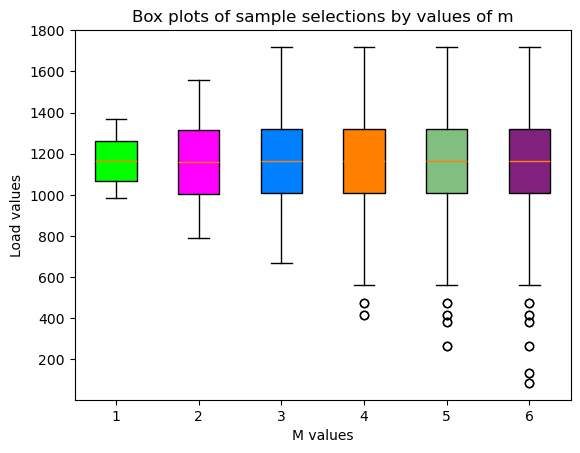

Original sample count: 73440
Downsized to chosen  : 72608 (832 removed)


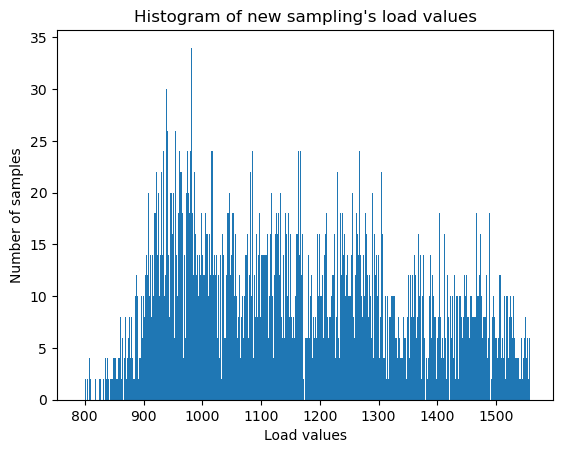

<Figure size 640x480 with 0 Axes>

In [8]:
# List of values for m
ms = [1, 2, 3, 4, 5, 6]
    
total_number_samples = mc.plot_results_for_values_m(out_dir + '/m_values', ms, array)

# Preferred value of m based on plot
preferred_m_value = 2
array_no_outliers = mc.reject_outliers(array[:, 0], preferred_m_value)

new_sample_count = len(array_no_outliers)
count_diff = total_number_samples - new_sample_count
print(f"Original sample count: {total_number_samples}")
print(f"Downsized to chosen  : {new_sample_count} ({count_diff} removed)")
mc.plot_hist_of_reduced('out/outliers_removed', total_number_samples, array_no_outliers)

Get change targets for our state transitions

Load changes: shape = (72607,)
[  0.     -40.3358   0.     ...   0.     -76.8596   0.    ]


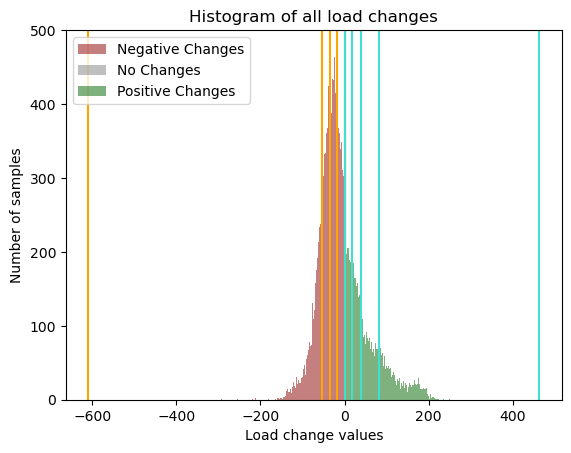

Negatives: Min = -609.49150, Q1 = -53.40170, Q2 = -34.59870, Q3 = -18.94970, Max = -0.01280
No changes: count = 36296
Positives: Min = 0.00160, Q1 = 17.35803, Q2 = 39.94595, Q3 = 83.03923, Max = 463.76650
All targets:
[-53.402, -34.599, -18.95, 0, 17.358, 39.946, 83.039]


<Figure size 640x480 with 0 Axes>

In [9]:
change_array = mc.get_change_array(array_no_outliers)
print(f"Load changes: shape = {change_array.shape}")
print(change_array)
negative_changes, no_changes, positive_changes = mc.get_changes_by_direction(change_array)
neg_min_value, neg_q1, neg_q2, neg_q3, neg_max_value, \
        pos_min_value, pos_q1, pos_q2, pos_q3, pos_max_value = \
        mc.get_changes_five_summary_stats(negative_changes, positive_changes)
mc.plot_change_summaries('out/changes', total_number_samples,
                          negative_changes, no_changes, positive_changes,
                          neg_min_value, neg_q1, neg_q2, neg_q3, neg_max_value,
                          pos_min_value, pos_q1, pos_q2, pos_q3, pos_max_value)
print(f"Negatives: Min = {neg_min_value:.5f}, Q1 = {neg_q1:.5f}, Q2 = {neg_q2:.5f}, "
          f"Q3 = {neg_q3:.5f}, Max = {neg_max_value:.5f}")
print(f"No changes: count = {len(no_changes)}")
print(f"Positives: Min = {pos_min_value:.5f}, Q1 = {pos_q1:.5f}, Q2 = {pos_q2:.5f}, "
          f"Q3 = {pos_q3:.5f}, Max = {pos_max_value:.5f}")

# Number of change states (described above)
num_changes, num_months = 7, 12
targets = [neg_q1, neg_q2, neg_q3, 0, pos_q1, pos_q2, pos_q3]
print(f"All targets:\n{[round(target, 3) for target in targets]}")

Create our model and define our paths

In [10]:
# OUTPUT FILE PATHS
train_out_path = 'out/train_preds_v_acts'
train_saved_model_path = 'out/post_train_markov_chain_model'
test_out_path = 'out/test_preds_v_acts'
test_saved_model_path = 'out/post_test_markov_chain_model'

# CREATE AND TRAIN THE MARKOV CHAIN
# Create an instance of Markov chain for the number of months and number of changes
markov_chain = mc.MarkovChain(num_changes, num_months, targets)

Training set (printing info every 1000 samples)

In [11]:
# Start processing the data (array) and make a prediction for the next sample's load
print(f"Starting training")
start_time = time.time()
train_preds, train_acts = markov_chain.predict_and_train(train_out_path, array, prnt_every=0)
end_time = time.time()
execution_time = end_time - start_time
print(f"Finished in {execution_time:.3f} seconds.")
mc.plot_preds_versus_acts(train_out_path, array, train_preds, train_acts)
markov_chain.save_instance(train_saved_model_path)

# Print training results
train_preds, train_acts = mc.load_results(train_out_path + ".txt")
mc.print_mse_and_results(train_preds, train_acts, 10000)

Starting training
Finished in 176.262 seconds.r2 = 0.9451591207949931
Years: [2015. 2016. 2017. 2018. 2019.]
Counts: [16078 17568 17520 17520  4754]
Markov Chain instance saved to 'out/post_train_markov_chain_model.pkl'.
Sample index: <predicted load> vs. <actual load> (<percentage diff> %)
0: 954.20 vs. 913.87 (4.41 % diff)
10000: 1304.78 vs. 1384.12 (5.73 % diff)
20000: 1271.99 vs. 1264.98 (0.55 % diff)
30000: 911.57 vs. 892.02 (2.19 % diff)
40000: 1252.96 vs. 1308.23 (4.22 % diff)
50000: 1286.46 vs. 1357.30 (5.22 % diff)
60000: 1045.23 vs. 1008.29 (3.66 % diff)
70000: 1365.84 vs. 1452.74 (5.98 % diff)

MSE = 2022.1813812784371
RMSE = 44.968671108655606


<Figure size 640x480 with 0 Axes>

Get the testing set 

In [12]:
test_df = mc.get_testing_df("./data/test_dataframes.xlsx")
test_array = test_df.values
print(f"{type(test_array)}: shape = {test_array.shape}")
print(test_array[:5])
print(...)
print(test_array[-5:])

<class 'numpy.ndarray'>: shape = (168, 3)
[[1161.6177    4.     2019.    ]
 [1130.4635    4.     2019.    ]
 [1093.8777    4.     2019.    ]
 [1083.0332    4.     2019.    ]
 [1081.2705    4.     2019.    ]]
Ellipsis
[[1169.1743    4.     2019.    ]
 [1156.5246    4.     2019.    ]
 [1133.0677    4.     2019.    ]
 [1098.2215    4.     2019.    ]
 [1078.8903    4.     2019.    ]]


Testing set against model

In [13]:
markov_chain = mc.load_instance(train_saved_model_path)
print(f"Starting testing")
start_time = time.time()
test_preds, test_acts = markov_chain.predict_and_train(test_out_path, test_array, prnt_every=0)
end_time = time.time()
execution_time = end_time - start_time
print(f"Finished in {execution_time:.3f} seconds.")

Instance loaded from 'out/post_train_markov_chain_model.pkl'.
Starting testing
Finished in 0.036 seconds.= 0.9064022589036977


Evaluate and save model

In [14]:
if test_preds is None:
    test_preds, test_acts = mc.load_results(test_out_path + ".txt")
mc.print_mse_and_results(test_preds, test_acts, 10)
markov_chain.save_instance(test_saved_model_path)

Sample index: <predicted load> vs. <actual load> (<percentage diff> %)
0: 1130.46 vs. 1093.88 (3.34 % diff)
10: 1403.73 vs. 1381.37 (1.62 % diff)
20: 1264.82 vs. 1212.08 (4.35 % diff)
30: 1062.41 vs. 1116.67 (4.86 % diff)
40: 1243.09 vs. 1310.54 (5.15 % diff)
50: 1046.13 vs. 1059.19 (1.23 % diff)
60: 1651.48 vs. 1622.43 (1.79 % diff)
70: 1200.56 vs. 1156.15 (3.84 % diff)
80: 1589.80 vs. 1618.47 (1.77 % diff)
90: 1409.25 vs. 1388.30 (1.51 % diff)
100: 1075.68 vs. 1191.10 (9.69 % diff)
110: 1524.48 vs. 1410.09 (8.11 % diff)
120: 1125.32 vs. 1098.79 (2.41 % diff)
130: 1411.64 vs. 1417.88 (0.44 % diff)
140: 1193.41 vs. 1151.09 (3.68 % diff)
150: 992.25 vs. 1005.77 (1.34 % diff)
160: 1089.62 vs. 1158.45 (5.94 % diff)

MSE = 3306.252451979999
RMSE = 57.500021321561256
Markov Chain instance saved to 'out/post_test_markov_chain_model.pkl'.
